**Twitter Dataset Emotional Analysis**

In [ ]:
#importing few required libraries
!pip install tweet-preprocessor 2>/dev/null 1>/dev/null
import preprocessor as p
import numpy as np 
import pandas as pd 
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from tqdm import tqdm

In [ ]:
#data preparation, taking the data set for cleaning purpose for sentiment analysis
data1 = pd.read_csv("text_emotion.csv")
misspell_data = pd.read_csv("text_emotion.csv",sep=":",names=["correction","misspell"])
misspell_data.misspell = misspell_data.misspell.str.strip()
misspell_data.misspell = misspell_data.misspell.str.split(" ")
misspell_data = misspell_data.explode("misspell").reset_index(drop=True)
misspell_data.drop_duplicates("misspell",inplace=True)
miss_corr = dict(zip(misspell_data.misspell, misspell_data.correction))

#Sample of the dict
{v:miss_corr[v] for v in [list(miss_corr.keys())[k] for k in range(20)]}

{'#topicmaps': '1956972116,neutral,jansc,No Topic Maps talks at the Balisage Markup Conference 2009   Program online at http',
 '(via': '1956972116,neutral,jansc,No Topic Maps talks at the Balisage Markup Conference 2009   Program online at http',
 '//plurk.com/p/wxidk': '1956975876,neutral,jubaldo,feels strong contractions but wants to go out.  http',
 '//tr.im/mL6Z': '1956972116,neutral,jansc,No Topic Maps talks at the Balisage Markup Conference 2009   Program online at http',
 '//www.djhero.com/': '1956968636,worry,mcsleazy,Hmmm. http',
 '@bobdc)': '1956972116,neutral,jansc,No Topic Maps talks at the Balisage Markup Conference 2009   Program online at http',
 'BC': '1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14',
 'bf': '1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14',
 "didn't": '1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14',
 'down': '1956968636,worry,mcsleazy,Hmmm. http',
 'friends': '1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14',
 'go': '

In [ ]:
#using this function we are removing the missplled words ex:- 'acord': 'accord' (few are listed above)
def misspelled_correction(val):
    for x in val.split(): 
        if x in miss_corr.keys(): 
            val = val.replace(x, miss_corr[x]) 
    return val

In [ ]:
#cleaning the data i.e making corrections to the mispelled data
data1["clean_content"] = data1.content.apply(lambda x : misspelled_correction(x))

In [ ]:
#importing/installing contractions library
import sys  
!{sys.executable} -m pip install contractions

     |████████████████████████████████| 284 kB 5.4 MB/s 
     |████████████████████████████████| 321 kB 46.9 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85453 sha256=dd235426e00896932cbe8c1b4903a968c04dd4d8c0bdb2cc2965f2113bf86a9b
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
#logic for contractions i.e replacing the contractions with its relavent meaning Ex:- I'll be --> I will be 
contractions = pd.read_csv("contractions.csv")
index=0
limit = 10000
con =[]
for i in contractions.Contraction :
  for word in i.split():
    con.append(word) 
  
  index += 1
  if index == limit:
    break

for word in con:
  con1 = contractions

cont_dic = dict(zip(contractions.Contraction, contractions.Meaning))

In [ ]:
#function which does it
def cont_to_meaning(val): 
  
    for x in val.split(): 
        if x in cont_dic.keys(): 
            val = val.replace(x, cont_dic[x]) 
    return val

In [ ]:
#removing the contractions for the data in the dataset
data1.clean_content = data1.clean_content.apply(lambda x : cont_to_meaning(x))

In [ ]:
#Removing some important charcters in the data like URLS and empty spaces etc. 
p.set_options(p.OPT.MENTION, p.OPT.URL)

In [ ]:
data1["clean_content"]=data1.content.apply(lambda x : p.clean(x))

In [ ]:
#this function uses to remove punctuations
def punctuation(val): 
  
    punctuations = '''()-[]{};:'"\,<>./@#$%^&_~'''
  
    for x in val.lower(): 
        if x in punctuations: 
            val = val.replace(x, " ") 
    return val
#testing with a small dataset
punctuation("test @ #ldfldlf??? !! ")

'test    ldfldlf??? !! '

In [ ]:
#installing emoji library
!pip install emoji

     |████████████████████████████████| 170 kB 5.3 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=035fd2331c8a2258b618906d4bab0bbdd4999322ae10ad59029c0b772d76bc8c
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [ ]:
#removing the emojis in the data
import emoji
data1.clean_content = data1.clean_content.apply(lambda x : ' '.join(punctuation(emoji.demojize(x)).split()))

In [ ]:
#this function cleans(removing the misspelles, converting contractions) the words/characters in a sentence  and again joining the vales/keys to 
#to form a meaningfull sentecnce
def clean_text(val):
    val = misspelled_correction(val)
    val = cont_to_meaning(val)
    val = p.clean(val)
    val = ' '.join(punctuation(emoji.demojize(val)).split())
    
    return val

In [ ]:
#Remove empty comments 
data1 = data1[data1.clean_content != ""]


In [ ]:
# Here we are using 12 different emotions as listed below
#12 emotions are (neutral, worry, happiness, sadness, love, surprise, fun, relief, hate, empty, enthusiasm, boredom and anger) 
#and the goal of it take a given sentence and find each of emotional percentages.
data1.sentiment.value_counts()


neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [ ]:
#setting an id to each of the emotion
sent_to_id  = {"empty":0, "sadness":1,"enthusiasm":2,"neutral":3,"worry":4,
                        "surprise":5,"love":6,"fun":7,"hate":8,"happiness":9,"boredom":10,"relief":11,"anger":12}

In [ ]:
#setting the id to each headline based on there emotion
data1["sentiment_id"] = data1['sentiment'].map(sent_to_id)


In [ ]:
data

,publish_date,headline_text,year,month,date,word_count,char_count,mean_word_length,punctuation_count,stop_word_count
0,20030219,aba decides against community broadcasting lic...,2003,2,19,50,50,7.500000,0,1
1,20030219,act fire witnesses must be aware of defamation,2003,2,19,46,46,4.875000,0,2
2,20030219,a g calls for infrastructure protection summit,2003,2,19,46,46,5.714286,0,2
3,20030219,air nz staff in aust strike for pay rise,2003,2,19,40,40,3.555556,0,2
4,20030219,air nz strike to affect australian travellers,2003,2,19,45,45,5.571429,0,1
...,...,...,...,...,...,...,...,...,...,...
1226253,20201231,what abc readers learned from 2020 looking bac...,2020,12,31,59,59,4.454545,0,4
1226254,20201231,what are the south african and uk variants of ...,2020,12,31,54,54,4.000000,0,5
1226255,20201231,what victorias coronavirus restrictions mean f...,2020,12,31,62,62,6.000000,0,2
1226256,20201231,whats life like as an american doctor during c...,2020,12,31,50,50,4.666667,0,3


In [ ]:
#importing the relavent libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#using the label encoder to encode the data(for train and test data)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data1.sentiment_id)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y = onehot_encoder.fit_transform(integer_encoded)

In [ ]:
#splitting the data has test and train data to test our model after training it with training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data1.clean_content,Y, random_state=1995, test_size=0.2, shuffle=True)


In [ ]:
#view of the cleaned data with its emotion id
data1

,tweet_id,sentiment,author,content,clean_content,sentiment_id
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,t1956976312 sadness amy xx ether rad1956976312...,0
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,L1956989601 hate M0anique cayogial i wanted to...,1
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,1963424826 worry TRob55 Working I cannot wait ...,1
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,1961375665 neutral apesxessence flyguyvan can ...,2
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,dannycastillo 1962332503 love crystalisgnar pa...,3
...,...,...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor,JohnLloydTaylor,3
39996,1753919001,love,drapeaux,Happy Mothers Day All my love,1750999670 surprise sarahsss sarahdope http 16...,6
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...,1750999670 surpr1956968636 worry mcsleazy Hmmm...,6
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,niariley WASS1957082503 worry teenicky jessica...,9


In [ ]:
#installing required library
!pip install sequence

  Created wheel for sequence: filename=sequence-0.3.4-py3-none-any.whl size=5415 sha256=67e30ea2879810ebace4685f44c02781ff9532ab77d29fef5c9e391eafb0be82
  Stored in directory: /root/.cache/pip/wheels/86/0f/5f/c8f0008d7a90c4511ea066fcabf9afa18194ae7644ec937d02
  Created wheel for daytime: filename=daytime-0.4-py3-none-any.whl size=2418 sha256=e0f27f16781ff1ac3b3a0630f22c6d58ce190da22abbd69a7a5c8ea37ceb7904
  Stored in directory: /root/.cache/pip/wheels/3c/fa/b5/121fe6d709bf3a89a03512710454c10382c49eb6bbc3577b22
Successfully built sequence daytime


In [ ]:
#LSTM
# using keras tokenizer here
import keras
from keras import preprocessing
import tokenize
from keras.preprocessing.text import Tokenizer
import sequence
token = Tokenizer(num_words=None)
max_len = 160
Epoch = 5
token.fit_on_texts(list(X_train) + list(X_test))
X_train_pad = keras.preprocessing.sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=max_len)
X_test_pad = keras.preprocessing.sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=max_len)

In [ ]:
#word index
w_idx = token.word_index

In [ ]:
#installing embeddings and importing it
!pip install Embeddings
import embeddings

In [ ]:
import embeddings
from keras.layers import Embedding,Dense,SpatialDropout1D,LSTM,core
from tensorflow import keras
embed_dim = 160
lstm_out = 250

model = keras.Sequential()
model.add(Embedding(len(w_idx) +1 , embed_dim,input_length = X_test_pad.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(13, activation='softmax'))
#adam rmsprop 
model.compile(loss = "categorical_crossentropy", optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 160, 160)          11571520  
                                                                 
 spatial_dropout1d (SpatialD  (None, 160, 160)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 250)               411000    
                                                                 
 dense (Dense)               (None, 13)                3263      
                                                                 
Total params: 11,985,783
Trainable params: 11,985,783
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 32

In [ ]:
#training the model
model.fit(X_train_pad, y_train, epochs = Epoch, batch_size=batch_size,validation_data=(X_test_pad, y_test))

Epoch 1/5
1000/1000 [==============================] - 1324s 1s/step - loss: 2.1313 - accuracy: 0.2443 - val_loss: 2.0981 - val_accuracy: 0.2567
Epoch 2/5
1000/1000 [==============================] - 1316s 1s/step - loss: 1.9911 - accuracy: 0.3138 - val_loss: 2.0757 - val_accuracy: 0.2754
Epoch 3/5
1000/1000 [==============================] - 1318s 1s/step - loss: 1.6751 - accuracy: 0.4377 - val_loss: 2.2286 - val_accuracy: 0.2522
Epoch 4/5
1000/1000 [==============================] - 1315s 1s/step - loss: 1.3273 - accuracy: 0.5523 - val_loss: 2.4589 - val_accuracy: 0.2467
Epoch 5/5
1000/1000 [==============================] - 1311s 1s/step - loss: 1.0753 - accuracy: 0.6328 - val_loss: 2.7095 - val_accuracy: 0.2304


In [ ]:
#creating a function to get the sentiment of the data/sentence 
def get_sentiment(model,text):
    text = clean_text(text)
    #tokenize
    twt = token.texts_to_sequences([text])
    twt = sequence.pad_sequences(twt, maxlen=max_len, dtype='int32')
    sentiment = model.predict(twt,batch_size=1,verbose = 2)
    sent = np.round(np.dot(sentiment,100).tolist(),0)[0]
    result = pd.DataFrame([sent_to_id.keys(),sent]).T
    result.columns = ["sentiment","percentage"]
    result=result[result.percentage !=0]
    return result

In [ ]:
#creating a function for visual representation of the percentages of emotions form the guven set of data.
def plot_result(df):
    colors=['#D50000','#000000','#008EF8','#F5B27B','#EDECEC','#D84A09','#019BBD','#FFD000','#7800A0','#098F45','#807C7C','#85DDE9','#F55E10']
    fig = go.Figure(data=[go.Pie(labels=df.sentiment,values=df.percentage, hole=.3,textinfo='percent',hoverinfo='percent+label',marker=dict(colors=colors, line=dict(color='#000000', width=2)))])
    fig.show()
    colors={'love':'rgb(213,0,0)','empty':'rgb(0,0,0)',
                    'sadness':'rgb(0,142,248)','enthusiasm':'rgb(245,178,123)',
                    'neutral':'rgb(237,236,236)','worry':'rgb(216,74,9)',
                    'surprise':'rgb(1,155,189)','fun':'rgb(255,208,0)',
                    'hate':'rgb(120,0,160)','happiness':'rgb(9,143,69)',
                    'boredom':'rgb(128,124,124)','relief':'rgb(133,221,233)',
                    'anger':'rgb(245,94,16)'}
    col_2={}
    for i in result.sentiment.to_list():
        col_2[i]=colors[i]
    fig = px.pie(df, values='percentage', names='sentiment',color='sentiment',color_discrete_map=col_2,hole=0.3)
    fig.show()

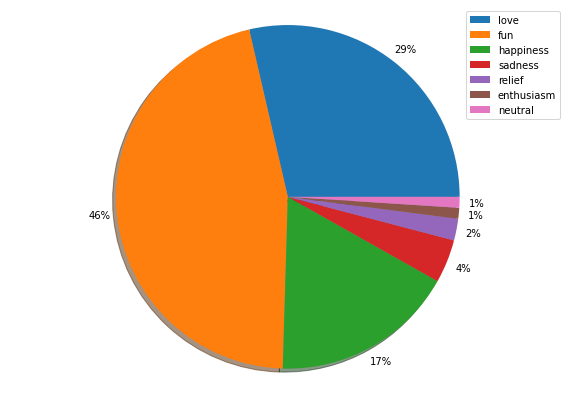

In [ ]:
#testing the model with a given sentence
result =get_sentiment(model,"Had an absolutely brilliant day ðŸ˜ loved seeing an old friend and reminiscing")
plot_result(result)

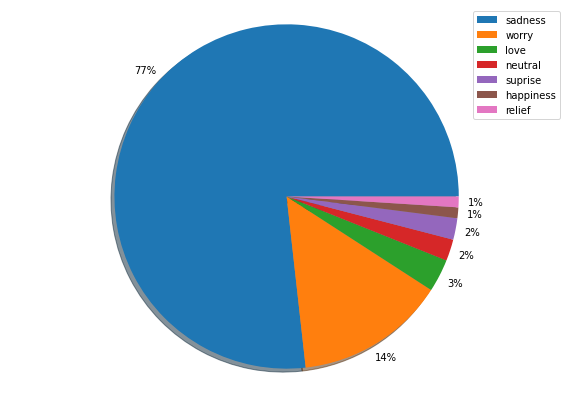

In [ ]:
#testing the model with the given sentence
result =get_sentiment(model,"The pain my heart feels is just too much for it to bear. Nothing eases this pain. I can’t hold myself back. I really miss you")
plot_result(result)

In [ ]:
#ACCURACY OF THE MODEL

from sklearn.metrics import accuracy_score

print(accuracy_score(Y_test_pad, model.predict(X_test_pad)))

0.89


In [ ]:
#Roberta base model
!pip install tensorflow
import tensorflow as tf
AUTO = tf.data.experimental.AUTOTUNE
MODEL = 'roberta-base'

In [ ]:
#function to read the dta from file
def read_data(file_name):
    with open(file_name,'r') as f:
        word_vocab = set() 
        word2vector = {}
        for line in f:
            line_ = line.strip() 
            words_Vec = line_.split()
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector


In [ ]:
#vocab, word_to_idx =read_data("glove.6B.50d.txt")
vocab, word_to_idx =read_data("glove.6B.200d.txt")

Total Words in DataSet: 400000


In [ ]:
embedding_matrix = np.zeros((len(w_idx) + 1, 200))
for word, i in w_idx.items():
    embedding_vector = word_to_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embed_dim = 200
lstm_out = 250

model_lstm_gwe = keras.Sequential()
model_lstm_gwe.add(Embedding(len(w_idx) +1 , embed_dim,input_length = X_test_pad.shape[1],weights=[embedding_matrix],trainable=False))
model_lstm_gwe.add(SpatialDropout1D(0.2))
model_lstm_gwe.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model_lstm_gwe.add(keras.layers.Dense(13, activation='softmax'))
#adam rmsprop 
model_lstm_gwe.compile(loss = "categorical_crossentropy", optimizer='adam',metrics = ['accuracy'])
print(model_lstm_gwe.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 160, 200)          14464400  
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 160, 200)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 250)               451000    
                                                                 
 dense_1 (Dense)             (None, 13)                3263      
                                                                 
Total params: 14,918,663
Trainable params: 454,263
Non-trainable params: 14,464,400
_________________________________________________________________
None


In [ ]:
batch_size = 32


In [ ]:
#training the model
model_lstm_gwe.fit(X_train_pad, y_train, epochs = Epoch, batch_size=batch_size,validation_data=(X_test_pad, y_test))

Epoch 1/5
1000/1000 [==============================] - 1136s 1s/step - loss: 2.1472 - accuracy: 0.2342 - val_loss: 2.1079 - val_accuracy: 0.2510
Epoch 2/5
1000/1000 [==============================] - 1131s 1s/step - loss: 2.1056 - accuracy: 0.2593 - val_loss: 2.0935 - val_accuracy: 0.2537
Epoch 3/5
1000/1000 [==============================] - 1131s 1s/step - loss: 2.0790 - accuracy: 0.2694 - val_loss: 2.0920 - val_accuracy: 0.2626
Epoch 4/5
1000/1000 [==============================] - 1129s 1s/step - loss: 2.0529 - accuracy: 0.2791 - val_loss: 2.0818 - val_accuracy: 0.2648
Epoch 5/5
1000/1000 [==============================] - 1130s 1s/step - loss: 2.0233 - accuracy: 0.2903 - val_loss: 2.0754 - val_accuracy: 0.2720


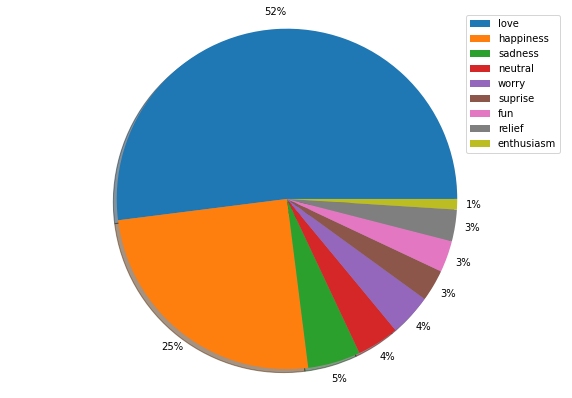

In [ ]:
#testing the model with a given sentence same as used above
result =get_sentiment(model_lstm_gwe,"Had an absolutely brilliant day ðŸ˜ loved seeing an old friend and reminiscing")
plot_result(result)

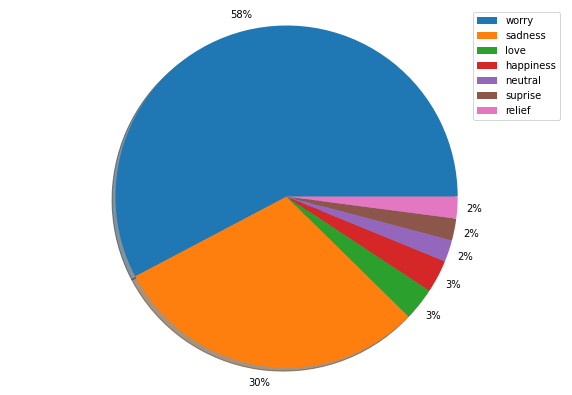

In [ ]:
#testing the model with a given sentence same as used above
result =get_sentiment(model_lstm_gwe,"The pain my heart feels is just too much for it to bear. Nothing eases this pain. I can’t hold myself back. I really miss you")
plot_result(result)

In [ ]:
#ACCURACY OF THE MODEL

from sklearn.metrics import accuracy_score

print(accuracy_score(ytest, model.predict(xtest)))

0.8623853211009175


In [ ]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        #padding='max_length',
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

def build_model(transformer, max_len=160):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(13, activation='softmax')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
#Baisc Albert Base model
!pip install transformers
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
MODEL = 'albert-base-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
X_train_t = regular_encode(X_train, tokenizer, maxlen=max_len)
X_test_t = regular_encode(X_test, tokenizer, maxlen=max_len)

In [ ]:
X_train_t = regular_encode(X_train, tokenizer, maxlen=max_len)
X_test_t = regular_encode(X_test, tokenizer, maxlen=max_len)

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train_t, y_train))
    .repeat()
    .shuffle(1995)
    .batch(batch_size)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test_t, y_test))
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)


In [ ]:
transformer_layer = TFAutoModel.from_pretrained(MODEL)
albert = build_model(transformer_layer, max_len=max_len)
albert.summary()

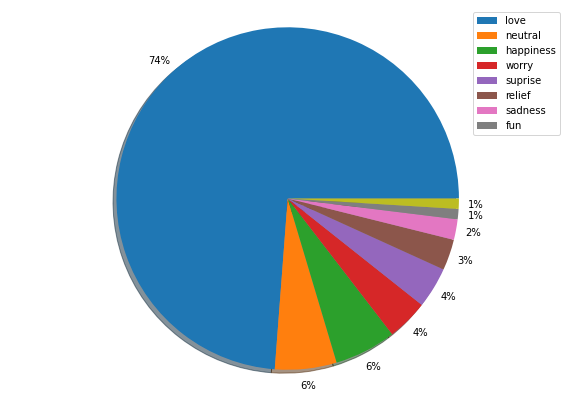

In [ ]:
#testing of the model with one of the same sentence that is used above.
result =get_sentiment2(albert,"Had an absolutely brilliant day ðŸ˜ loved seeing an old friend and reminiscing")
plot_result(result)

In [ ]:
#ACCURACY OF THE MODEL

from sklearn.metrics import accuracy_score

print(accuracy_score(Y_test_t, model.predict(X_test_t)))


0.79


**Accuracy of the model**

89% for the LSTM model,

86.23%(approx) for Robert Model,

79% for the Albert Model(basic)